<a href="https://colab.research.google.com/github/leahnagy/liquor_predictor/blob/main/code/proj_fbprophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 1.2 MB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 35 kB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6637996 sha256=b4e48e98a01f5a2503cc23aef016e29723bb75a8e7f6b44dd76fc44444b0f623
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the p

In [ ]:
import pandas as pd
from fbprophet import Prophet

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/cleaned_liquor.csv'
df = pd.read_csv(path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.shape

(24396811, 25)

In [ ]:
df = df[df['date'] > '2017-12-31']

In [ ]:
# calculate number of nulls
df.isnull().sum(axis=0)

Unnamed: 0             0
invoice_num            0
date                   0
store_num              0
store_name             0
address             7358
city                7358
zip_code            7358
county              7358
category            5621
category_name       5621
vendor_number          7
vendor_name            7
item_num               0
item_description       0
pack                   0
bottle_volume          0
bottle_cost            0
bottle_retail          0
bottles_sold           0
sales_usd              0
sales_liters           0
sales_gallons          0
year                   0
month                  0
dtype: int64

In [ ]:
# drop nulls
df = df.dropna()

In [ ]:
# Filter for vodka products only
df = df[df['category_name'].str.contains("Vodka")]

In [ ]:
df.shape

(2825713, 25)

In [ ]:
# drop extra column
df = df.drop('Unnamed: 0', axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2825713 entries, 1028819 to 24381910
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   invoice_num       object 
 1   date              object 
 2   store_num         int64  
 3   store_name        object 
 4   address           object 
 5   city              object 
 6   zip_code          object 
 7   county            object 
 8   category          float64
 9   category_name     object 
 10  vendor_number     float64
 11  vendor_name       object 
 12  item_num          object 
 13  item_description  object 
 14  pack              int64  
 15  bottle_volume     int64  
 16  bottle_cost       float64
 17  bottle_retail     float64
 18  bottles_sold      int64  
 19  sales_usd         float64
 20  sales_liters      float64
 21  sales_gallons     float64
 22  year              int64  
 23  month             int64  
dtypes: float64(7), int64(6), object(11)
memory usage: 539.0+ MB


In [ ]:
# filter for only polk county to test FB Prophet
polk_df = df.loc[df['county']=='POLK']

In [ ]:
# put dates in correct format
polk_df['ds'] = pd.to_datetime(['{}-{}-01'.format(y, m) for y, m in
                                zip(polk_df.year, polk_df.month)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
polk_df.head()

,invoice_num,date,store_num,store_name,address,city,zip_code,county,category,category_name,...,bottle_volume,bottle_cost,bottle_retail,bottles_sold,sales_usd,sales_liters,sales_gallons,year,month,ds
1028819,INV-14210900002,2018-09-04,4617,Lickety Liquor,2501 HUBBELL AVE,Des Moines,50317,POLK,1031100.0,American Vodkas,...,500,4.70,7.05,6,42.30,3.00,0.79,2018,9,2018-09-01
5144326,INV-18421900010,2019-03-28,4136,Fareway Stores #983 / Grimes,351 Gateway Dr,Grimes,50111,POLK,1031200.0,American Flavored Vodka,...,1750,14.00,21.00,6,126.00,10.50,2.77,2019,3,2019-03-01
5144708,INV-17877000003,2019-03-04,5338,Kum & Go #539/ NW 2nd Ave,5050 NW 2nd Ave,Des Moines,50313,POLK,1031100.0,American Vodkas,...,750,3.34,5.01,12,60.12,9.00,2.37,2019,3,2019-03-01
5145430,INV-18136800003,2019-03-14,5698,Casey's #3746 / Grimes,1650 NE Beaver Brooke Blvd,Grimes,50111,POLK,1031100.0,American Vodkas,...,375,1.86,2.79,9,25.11,3.37,0.89,2019,3,2019-03-01
5145724,INV-18049000028,2019-03-11,5338,Kum & Go #539/ NW 2nd Ave,5050 NW 2nd Ave,Des Moines,50313,POLK,1031100.0,American Vodkas,...,375,3.50,5.25,10,52.50,3.75,0.99,2019,3,2019-03-01


In [ ]:
# group by ds
polk_df = polk_df.groupby(['ds']).sales_usd.sum().reset_index()

In [ ]:
polk_df.head()

,ds,sales_usd
0,2018-01-01,1185550.24
1,2018-02-01,1345511.36
2,2018-03-01,1512580.09
3,2018-04-01,1512348.58
4,2018-05-01,1787986.46


In [ ]:
polk_df.columns = ['ds', 'y']
polk_df.head()

,ds,y
0,2018-01-01,1185550.24
1,2018-02-01,1345511.36
2,2018-03-01,1512580.09
3,2018-04-01,1512348.58
4,2018-05-01,1787986.46


In [ ]:
import warnings;
warnings.simplefilter('ignore')

In [ ]:
polk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      55 non-null     datetime64[ns]
 1   y       55 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1008.0 bytes


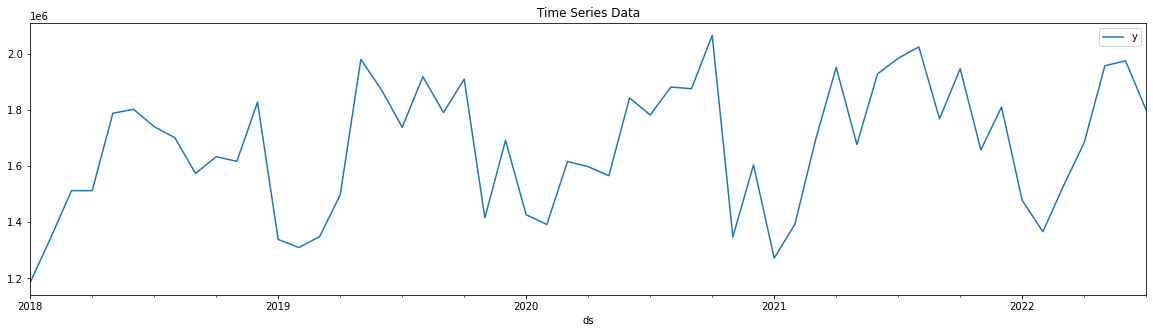

In [ ]:
# plot past time series data
polk_df.plot(x='ds', y='y', figsize=(20, 5), title='Time Series Data')

## Train Model with Prophet Using Test Data to Compare Accuracy

In [ ]:
df_tr = polk_df[polk_df['ds'] < '2021-01-01']
df_pr = polk_df[(polk_df['ds'] >= '2021-01-01') & (polk_df['ds'] < '2022-01-01')]
df_tr.shape, df_pr.shape

((36, 2), (12, 2))

In [ ]:
m = Prophet()
m.fit(df_tr)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)

forecast.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,1.602401e+06,1.126772e+06,1.313558e+06,1.602401e+06,1.602401e+06,-383166.116810,-383166.116810,-383166.116810,-383166.116810,-383166.116810,-383166.116810,0.0,0.0,0.0,1.219234e+06
1,2018-02-01,1.604747e+06,1.258116e+06,1.458680e+06,1.604747e+06,1.604747e+06,-245824.283542,-245824.283542,-245824.283542,-245824.283542,-245824.283542,-245824.283542,0.0,0.0,0.0,1.358923e+06
2,2018-03-01,1.606866e+06,1.345077e+06,1.525847e+06,1.606866e+06,1.606866e+06,-172065.624902,-172065.624902,-172065.624902,-172065.624902,-172065.624902,-172065.624902,0.0,0.0,0.0,1.434800e+06
3,2018-04-01,1.609212e+06,1.392453e+06,1.579397e+06,1.609212e+06,1.609212e+06,-116467.082470,-116467.082470,-116467.082470,-116467.082470,-116467.082470,-116467.082470,0.0,0.0,0.0,1.492745e+06
4,2018-05-01,1.611483e+06,1.700866e+06,1.884372e+06,1.611483e+06,1.611483e+06,181904.166437,181904.166437,181904.166437,181904.166437,181904.166437,181904.166437,0.0,0.0,0.0,1.793387e+06


In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
43,2021-08-01,1.700542e+06,1.794946e+06,1.980093e+06,1.700513e+06,1.700568e+06,186348.917232,186348.917232,186348.917232,186348.917232,186348.917232,186348.917232,0.0,0.0,0.0,1.886890e+06
44,2021-09-01,1.702853e+06,1.737724e+06,1.921135e+06,1.702819e+06,1.702885e+06,124304.846265,124304.846265,124304.846265,124304.846265,124304.846265,124304.846265,0.0,0.0,0.0,1.827158e+06
45,2021-10-01,1.705090e+06,1.874491e+06,2.061079e+06,1.705051e+06,1.705127e+06,261809.157727,261809.157727,261809.157727,261809.157727,261809.157727,261809.157727,0.0,0.0,0.0,1.966899e+06
46,2021-11-01,1.707401e+06,1.393742e+06,1.576288e+06,1.707356e+06,1.707444e+06,-225637.613707,-225637.613707,-225637.613707,-225637.613707,-225637.613707,-225637.613707,0.0,0.0,0.0,1.481764e+06
47,2021-12-01,1.709638e+06,1.636148e+06,1.821241e+06,1.709585e+06,1.709687e+06,21951.195461,21951.195461,21951.195461,21951.195461,21951.195461,21951.195461,0.0,0.0,0.0,1.731589e+06


Text(0, 0.5, 'Sales(USD)')

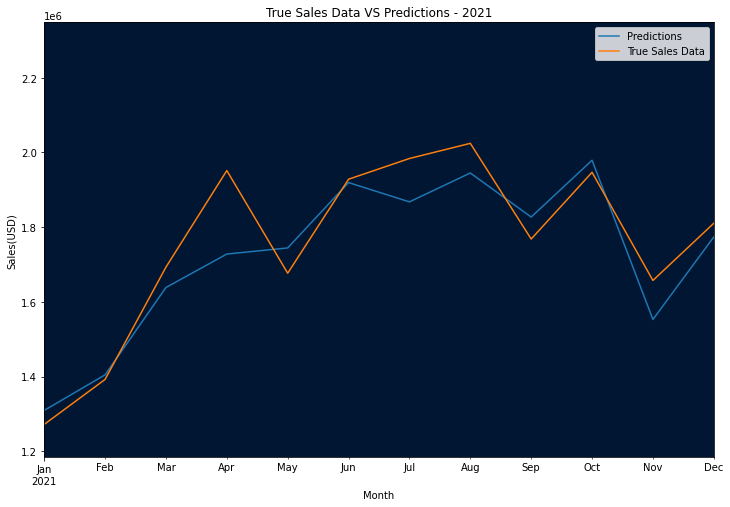

In [ ]:
# m.plot(forecast)
ax = forecast.plot(x='Date', y='Sales(USD)', 
                   legend=True, 
                   label='Predictions',
                   figsize=(12, 8))

df_pr.plot(x='ds',y='y',legend=True,label='True Sales Data',ax=ax,
           xlim=('2021-01-01', '2021-12-01'), title='True Sales Data VS Predictions - 2021')
ax.set_facecolor('#001633')
ax.set_xlabel('Month')
ax.set_ylabel('Sales(USD)')

# fig = px.line(forecast[forecast['Date'] >= '2022-09-01'], x='Date', y='Sales(USD)', markers=True)
# fig.update_traces(line_color='#85d5e6')
# fig.update_layout(title='Future Sales Forecast Polk County, Iowa',
#                   title_x=0.5, 
#                   xaxis_title='Month', 
#                   yaxis_title='Sales Forecast (USD)',
#                   plot_bgcolor='#001633',
#                   paper_bgcolor='#001633',
#                   font_color="#85d5e6")
# fig.update_xaxes(tickfont=dict(color='#85d5e6'), gridcolor='#798f9d')
# fig.update_yaxes(tickfont=dict(color='#85d5e6'), gridcolor='#798f9d')
# fig.show()

## Train Model with Prophet Using Entire Dataset

In [ ]:
m = Prophet()
m.fit(polk_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=60, freq='MS')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,1.601828e+06,1.136491e+06,1.346702e+06,1.601828e+06,1.601828e+06,-364697.728430,-364697.728430,-364697.728430,-364697.728430,-364697.728430,-364697.728430,0.0,0.0,0.0,1.237131e+06
1,2018-02-01,1.605355e+06,1.177620e+06,1.373728e+06,1.605355e+06,1.605355e+06,-325359.561429,-325359.561429,-325359.561429,-325359.561429,-325359.561429,-325359.561429,0.0,0.0,0.0,1.279996e+06
2,2018-03-01,1.608541e+06,1.327250e+06,1.525485e+06,1.608541e+06,1.608541e+06,-189590.640618,-189590.640618,-189590.640618,-189590.640618,-189590.640618,-189590.640618,0.0,0.0,0.0,1.418950e+06
3,2018-04-01,1.612068e+06,1.432479e+06,1.638776e+06,1.612068e+06,1.612068e+06,-74636.229656,-74636.229656,-74636.229656,-74636.229656,-74636.229656,-74636.229656,0.0,0.0,0.0,1.537432e+06
4,2018-05-01,1.615481e+06,1.663212e+06,1.877804e+06,1.615481e+06,1.615481e+06,154438.046824,154438.046824,154438.046824,154438.046824,154438.046824,154438.046824,0.0,0.0,0.0,1.769919e+06


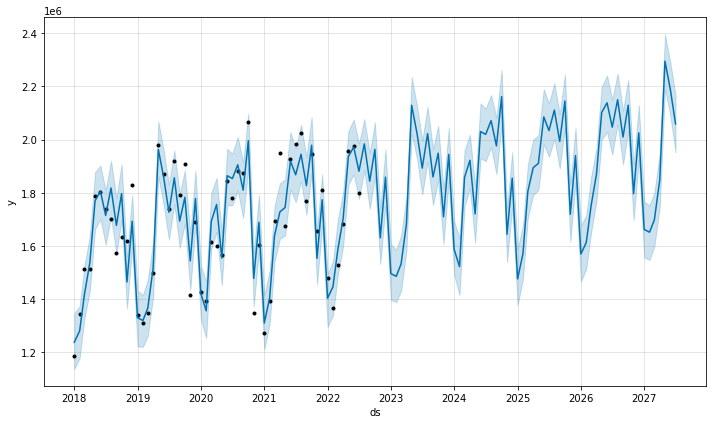

In [ ]:
plot1 = m.plot(forecast)

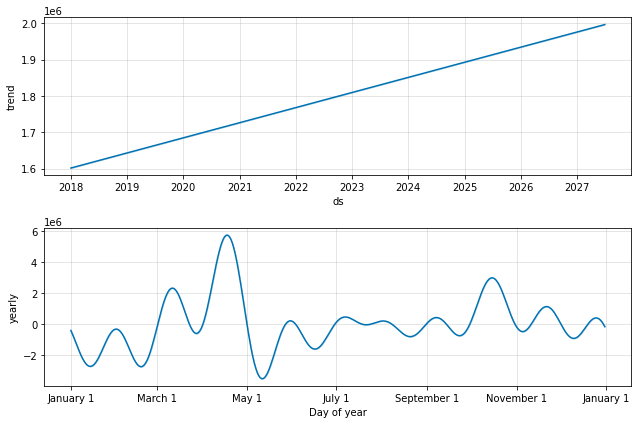

In [ ]:
plt2 = m.plot_components(forecast)

## Plotly Charts - Future Sales Predictions

In [ ]:
import plotly.express as px

In [ ]:
forecast.rename(columns={'ds':'Date', 'yhat':'Sales(USD)'}, inplace=True)

In [ ]:
fig = px.line(forecast[forecast['Date'] >= '2022-09-01'], x='Date', y='Sales(USD)', markers=True)
fig.update_traces(line_color='#85d5e6')
fig.update_layout(title='Future Sales Forecast Polk County, Iowa',
                  title_x=0.5, 
                  xaxis_title='Month', 
                  yaxis_title='Sales Forecast (USD)',
                  plot_bgcolor='#001633',
                  paper_bgcolor='#001633',
                  font_color="#85d5e6")
fig.update_xaxes(tickfont=dict(color='#85d5e6'), gridcolor='#798f9d')
fig.update_yaxes(tickfont=dict(color='#85d5e6'), gridcolor='#798f9d')
fig.show()